# discount factors and implied zero-coupon rates
# Cubic Spline Interpolation
# Linear Extrapolation
# pricing a new bond

In [ ]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d, CubicSpline
import matplotlib.pyplot as plt

In [ ]:
def security_cashflow(security_data):
    # Calculate the cash flows for each security
    df = security_data
    years = max(df['Maturity'])

    cashflow = np.zeros((len(df), years))

    for i, row in df.iterrows():
        maturity = row['Maturity']
        coupon = row['Coupon']

        for year in range(1, years + 1):
            if year < maturity:
                cashflow[i, year - 1] = coupon / 100 * row['Notional']
            elif year == maturity:
                cashflow[i, year - 1] = coupon / 100 * row['Notional'] + row['Notional']
            else:
                cashflow[i, year - 1] = 0

    cashflow_df = pd.DataFrame(cashflow)
    cashflow_df.columns = range(1, years + 1)
    cashflow_df.insert(0, 'Name', df['Name'])
    return cashflow_df

def calculate_discount_factor(security_data, cashflow):
    # Calculate the discount factors for each security
    df = security_data
    years = max(df['Maturity'])
    cashflow_df = cashflow
    discount_factor = np.zeros(years)

    # Calculate the discount factor
    for i, row in df.iterrows():
        maturity = row['Maturity']
        quote = row['Quote']

        # Initialize the numerator for discount factor calculation
        numerator = quote

        # Calculate the discounted cash flows
        for j in range(1, maturity):
            numerator -= cashflow_df.loc[i, maturity - j] * discount_factor[maturity - j - 1]

        discount_factor[maturity - 1] = numerator / cashflow_df.loc[i, maturity]

    discount_df = pd.DataFrame({'Term': range(1, years + 1), 'Discount Factor': discount_factor})

    return discount_df

def calculate_zero_rates(discount_factors):
    # Calculate the zero coupon rates from the discount factors
    zero_rates = []
    for year, discount_factor in enumerate(discount_factors['Discount Factor'], start=1):
        rate = (((1 / discount_factor) ** (1 / year)) - 1) * 100
        zero_rates.append(rate)
    zero_df = pd.DataFrame(zero_rates, columns=['Zero Rate'])
    zero_df.insert(0, 'Year', range(1, len(discount_factors) + 1))
    return zero_df

def calculate_bond_price(zero_rates, notional, maturity, coupon_rate):
    # Calculate the price of a bond given the zero rates
    years = len(zero_rates)
    cashflow = np.zeros(years)
    coupon_payment = notional * coupon_rate / 100

    for year in range(1, years + 1):
        cashflow[year - 1] = coupon_payment

    cashflow[-1] += notional

    discount_factors = 1 / ((1 + zero_rates['Zero Rate'] / 100) ** zero_rates['Year'])
    present_value = np.dot(cashflow, discount_factors)

    return present_value

def cubic_spline_interpolation(zero_rates):
    # Perform cubic spline interpolation on the zero rates
    x = zero_rates['Year'].values
    y = zero_rates['Zero Rate'].values / 100

    # Create the extrapolation function
    extrap_func = interp1d(x, y, kind='linear', fill_value='extrapolate')

    # Generate x-coordinates for plotting
    x_plot = np.linspace(min(x), 10, 100)

    # Evaluate the extrapolated y-coordinates
    y_plot = extrap_func(x_plot)

    # Extrapolate the zero coupon rates for periods 9 and 10
    x_extrap = np.array([len(zero_rates) + 1, len(zero_rates) + 2])
    y_extrap = extrap_func(x_extrap)

    # Create the cubic spline interpolation function
    cs = CubicSpline(x, y)

    # Generate x-coordinates for plotting
    x_plot_CubicSpline = np.linspace(1, 10, 100)

    # Evaluate the interpolated y-coordinates
    y_plot_CubicSpline = cs(x_plot_CubicSpline)

    # Evaluate the interpolated zero coupon rates for periods 9 and 10
    x_interp_CubicSpline = np.array([len(zero_rates) + 1, len(zero_rates) + 2])
    y_interp_CubicSpline = cs(x_interp_CubicSpline)

    # Plot the linear extrapolation line
    plt.plot(x_plot, y_plot, label='Linear Extrapolation')
    plt.scatter(x, y, color='red', label='Data Points')
    plt.scatter(x_extrap, y_extrap, color='green', label='Extrapolated Points')

    # Plot the cubic spline interpolation line
    plt.plot(x_plot_CubicSpline, y_plot_CubicSpline, label='Cubic Spline')
    plt.scatter(x_interp_CubicSpline, y_interp_CubicSpline, color='blue', label='Interpolated Points')

    plt.xlabel('Year')
    plt.ylabel('Zero Coupon Rate')
    plt.title('Linear Extrapolation and Cubic Spline Interpolation of Zero Coupon Rates')
    plt.legend()
    plt.grid(True)
    plt.show()

    return y_extrap[0], y_extrap[1], y_interp_CubicSpline[0], y_interp_CubicSpline[1]




#setting up

In [ ]:
# Input data
data = {
    'Name': ['T-bill I','T-bond I', 'T-bill II',  'T-bond II', 'T-bond III', 'T-bond IV'],
    'Notional': [100, 100, 100, 100, 100, 100],
    'Maturity': [1, 2, 3, 4, 5, 6],
    'Coupon': [0.00, 2.25, 0.00, 2.75, 1.00, 3.00],
    'Quote': [97.6345, 99.5029, 92.6356, 100.55, 92.5024, 101.9794]
}
security_data = pd.DataFrame(data)
security_data = security_data.sort_values('Maturity')

print("Sorted Data:")
print(security_data)
print()

cash_flow = security_cashflow(security_data)

print("Cash Flow:")
print(cash_flow)
print()


Sorted Data:
         Name  Notional  Maturity  Coupon     Quote
0    T-bill I       100         1    0.00   97.6345
1    T-bond I       100         2    2.25   99.5029
2   T-bill II       100         3    0.00   92.6356
3   T-bond II       100         4    2.75  100.5500
4  T-bond III       100         5    1.00   92.5024
5   T-bond IV       100         6    3.00  101.9794

Cash Flow:
         Name       1       2       3       4      5      6
0    T-bill I  100.00    0.00    0.00    0.00    0.0    0.0
1    T-bond I    2.25  102.25    0.00    0.00    0.0    0.0
2   T-bill II    0.00    0.00  100.00    0.00    0.0    0.0
3   T-bond II    2.75    2.75    2.75  102.75    0.0    0.0
4  T-bond III    1.00    1.00    1.00    1.00  101.0    0.0
5   T-bond IV    3.00    3.00    3.00    3.00    3.0  103.0



discount factors and implied zero-coupon rates

In [ ]:
discount_factors = calculate_discount_factor(security_data, cash_flow)

print("Discount Factors:")
print(discount_factors)
print()

zero_rates = calculate_zero_rates(discount_factors)

print("Zero Rates:")
print(zero_rates)
print()


Discount Factors:
   Term  Discount Factor
0     1         0.976345
1     2         0.951649
2     3         0.926356
3     4         0.902195
4     5         0.878672
5     6         0.855085

Zero Rates:
   Year  Zero Rate
0     1   2.422812
1     2   2.508900
2     3   2.582677
3     4   2.606505
4     5   2.620626
5     6   2.643580



pricing a new bond introduced into the market with a $100 notional, 6-year maturity and an annual coupon rate of 2.50%

In [ ]:
bond_price = calculate_bond_price(zero_rates, 100, 6, 2.50)

print("Bond Price:")
print(bond_price)
print()


Bond Price:
99.23424904322735



#100 notional (no coupon), a maturity date of 8 years and a market price of $80.6470.
##discount factor and zero rate associated with year 8
##discount factor and zero rate associated with year 7

In [ ]:
y8_price = 80.6470
y8_notional = 100
maturity_year = 8
y8_zero_rate = ((y8_notional / y8_price) ** (1 / maturity_year) - 1) * 100
y8_discount_factor = 1 / (1 + y8_zero_rate / 100) ** maturity_year

y7_zero_rate = ((y8_zero_rate / 100 - zero_rates.loc[5, 'Zero Rate'] / 100) +
                2 * zero_rates.loc[5, 'Zero Rate'] / 100) / 2 * 100
y7_discount_factor = 1 / (1 + y7_zero_rate / 100) ** 7

zero_rates.loc[6, 'Year'] = 7
zero_rates.loc[6, 'Zero Rate'] = y7_zero_rate

zero_rates.loc[7, 'Year'] = 8
zero_rates.loc[7, 'Zero Rate'] = y8_zero_rate

discount_factors.loc[6, 'Term'] = 7
discount_factors.loc[6, 'Discount Factor'] = y7_discount_factor

discount_factors.loc[7, 'Term'] = 8
discount_factors.loc[7, 'Discount Factor'] = y8_discount_factor

zero_rates.loc[6] = [7, y7_zero_rate]

zero_rates = zero_rates.sort_values('Year')
zero_rates = zero_rates.reset_index(drop=True)

print("Updated Zero Rates:")
print(zero_rates)
print()

print("Updated Discount Factors:")
print(discount_factors)
print()


Updated Zero Rates:
   Year  Zero Rate
0   1.0   2.422812
1   2.0   2.508900
2   3.0   2.582677
3   4.0   2.606505
4   5.0   2.620626
5   6.0   2.643580
6   7.0   2.684328
7   8.0   2.725076

Updated Discount Factors:
   Term  Discount Factor
0   1.0         0.976345
1   2.0         0.951649
2   3.0         0.926356
3   4.0         0.902195
4   5.0         0.878672
5   6.0         0.855085
6   7.0         0.830751
7   8.0         0.806470



# price of new bond introduced into the market with a $100 notional, 10-year maturity and an annual coupon rate of 3.50%

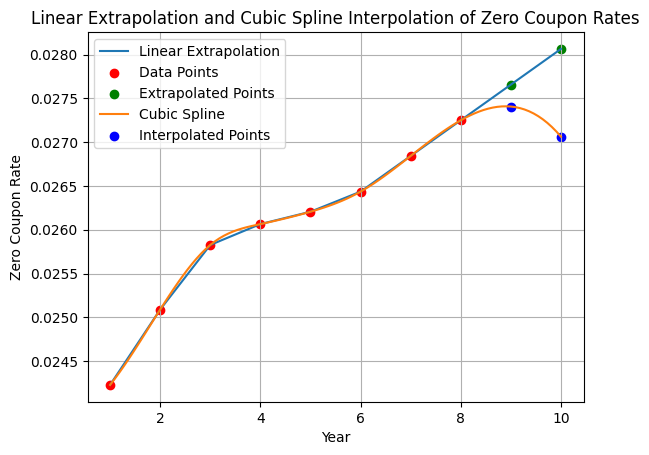

In [ ]:
le_9, le_10, cs_9, cs_10 = cubic_spline_interpolation(zero_rates)
zero_rates_cs = zero_rates
zero_rates.loc[8, 'Year'] = 9
zero_rates.loc[8, 'Zero Rate'] = le_9*100
zero_rates.loc[9, 'Year'] = 10
zero_rates.loc[9, 'Zero Rate'] = le_10*100

print("Updated Zero Rates using Linear Extrapolation:")
print(zero_rates)

ten_yr_bond_price = calculate_bond_price(zero_rates, 100, 10, 3.50)
print("Bond Price using Linear Extrapolation Estimated Zero Coupon Rate: ",ten_yr_bond_price)
print()


zero_rates_cs.loc[8, 'Year'] = 9
zero_rates_cs.loc[8, 'Zero Rate'] = cs_9*100
zero_rates_cs.loc[9, 'Year'] = 10
zero_rates_cs.loc[9, 'Zero Rate'] = cs_10*100

print("Updated Zero Rates using Cubic Spline Interpolation :")
print(zero_rates)


ten_yr_bond_price_cs = calculate_bond_price(zero_rates_cs, 100, 10, 3.50)
print("Bond Price using Cubic Spline Interpolation Estimated Zero Coupon Rate : ", ten_yr_bond_price_cs)
